In [1]:
import time
import numpy as np

import math
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random
import timeit
import copy
import pandas as pd
import warnings
import scipy.integrate as integrate
warnings.filterwarnings('ignore')
import sys,os
sys.path.append(os.path.abspath("../../"))
from LBL_funcs_waterRTM import *
import re
from sklearn.metrics import r2_score
#from scipy.special import erf
import scipy.special as sp

## extract file

In [2]:
import scipy.integrate as integrate
def calculateF(res,nu1,lamb,p_nu):
    # lamb = piece-wise
    # lamb=1 wavelength > 10000
    # lamb=0 wavelength ≤ 10000
    if lamb == 1:
        nu = nu1[:p_nu]
        items1 = ['F_n_abs', 'F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
        F_total = 0
        for item in items1:
            temp = res.item().get(item)
            F_i = integrate.trapz(temp[:,:p_nu], nu, axis=1)
            F_total += np.sum(F_i)
    if lamb == 0:
        nu = nu1[p_nu:]
        items1 = ['F_n_abs', 'F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
        F_total = 0
        for item in items1:
            temp = res.item().get(item)
            F_i = integrate.trapz(temp[:,p_nu:], nu, axis=1)
            F_total += np.sum(F_i)
    F_gas = res.item().get('F_n_abs')
    N_layer = F_gas.shape[0]
    F_1stLayer = res.item().get("F_n_abs")[-2]
    F_body = res.item().get("F_n_abs")[1:-2]
    F_edge = res.item().get('F_n_abs_rights') + res.item().get('F_n_abs_leftn') \
             + res.item().get('F_n_abs_fronte') + res.item().get('F_n_abs_backw')
    F_bottom= res.item().get('F_n_abs')[0]
    F_dw = res.item().get('F_n_dw')
    F_uw = res.item().get('F_n_uw')
    if lamb == 1:
        return F_total, F_bottom[:p_nu], F_1stLayer[:p_nu], F_body[:,:p_nu],\
               F_edge[:,:p_nu]#, F_dw[:,:p_nu], F_uw[:,:p_nu]
    if lamb == 0:
        return F_total, F_bottom[p_nu:], F_1stLayer[p_nu:], F_body[:,p_nu:],\
               F_edge[:,p_nu:]#, F_dw[:,p_nu:], F_uw[:,p_nu:]
    

def check_convergence(y, mean):
    diff = [np.nan]
    for i in range(1, len(y)):
        dy = abs(y[i] - y[i-1])
        diff.append(1-dy/mean*100)
    return diff

depth = 1
width = 20
long = 20
path = "./"
#path2 = './'
Fls = os.listdir(path)# + os.listdir(path2)

dnu = 5 # spectral resolutio
nu = np.arange(2500, 33333+dnu,dnu)  # cm-1

# all files.npy in the folder
Fls = [s for s in Fls if s.endswith('.npy')]
#Fls = [item for item in Fls if "_30layer" not in item and "_50layer" not in item]
#Fls = [item for item in Fls if "_300layer" not in item and "_250layer" not in item]
print(len(Fls))
Fls

8


['SWresults_50layer_1000bundle_diffuse.npy',
 'SWresults_80layer_1000bundle_diffuse.npy',
 'SWresults_120layer_1000bundle_diffuse.npy',
 'SWresults_200layer_1000bundle_diffuse.npy',
 'SWresults_30layer_1000bundle_diffuse.npy',
 'SWresults_100layer_1000bundle_diffuse.npy',
 'SWresults_150layer_1000bundle_diffuse.npy',
 'SWresults_180layer_1000bundle_diffuse.npy']

In [3]:
p_nu=1500
n = nu[p_nu]
print(n)
print(f'lamb={1/n}')

10000
lamb=0.0001


In [4]:
dnu = 5  # spectral resolution 0.1 is enough, 0.01 is too fine, especially for cloudy periods#33333
nu = np.arange(2500, 33333+dnu, dnu)  # spectral grid on wavenumber [cm-1]  # 0.3-4 um
data = np.genfromtxt('../../data/profiles/ASTMG173.csv', delimiter=',', skip_header=1,  # in wavenumber basis
                     names=['wavelength', 'column2', 'column3', '37d_irrdiance'])
ref_lam = data['wavelength'][1:]  # nm  # aviod lambda = 0, nu = inf
ref_E = data['37d_irrdiance'][1:]  # Direct+circumsolar W/[m2*nm]
ref_E_nu=-ref_E*ref_lam**2/1e7  # W/[m2*nm-1] tp W/[m2*cm-1]
F_dw_os = -np.interp(-nu, -1e7/ref_lam, ref_E_nu)  # W/[m2*cm-1] to W/cm-1

In [6]:
import re
layers = []
#Temp = []
for string in Fls:
    #match = re.search(r'_([\d.]+)layer', string)
    match = re.search(r'_([\d.]+)layer', string)
    if match:
        number = int(match.group(1))
        layers.append(number)
    # match = re.search(r'([\d.]+)_results', string)
    # if match:
    #     Temp.append(int(match.group(1)))
df1 = pd.DataFrame({"layer":layers})
df1['F_dw'] = df1.apply(lambda row:F_dw_os, axis=1)
df1['F_dw'][0].shape ==nu.shape

True

In [7]:
lamb = 1
# 2. extract all kinds of energy and save it as pandas
# allocate a empty dataframe
df2 = pd.DataFrame(columns=["F_total","F_bottom","F_1stLayer","F_body","F_edge"])#"F_dw","F_uw"])
for i in range(len(Fls)):
    try:
        res = np.load(path+Fls[i], allow_pickle=True)
    except:
        res = np.load(path+Fls[i], allow_pickle=True)
    columns = ["F_total", "F_bottom", "F_1stLayer", "F_body", "F_edge"]# "F_dw", "F_uw"]
    values = calculateF(res, nu, lamb,p_nu)
    df2.loc[i, columns] = values
df = pd.concat([df1, df2], axis=1)
del df1, df2
#df = dataf.sort_values(by='Temp')
if lamb == 1:
    nu = nu[:p_nu]
else:
    nu = nu[p_nu:]

### import coeff

In [8]:
from LBL_funcs_waterRTM import *
path = "./../../"
spectral="SW"
pond_type = 'homogeneous'  # 'gradiant'

ka_lq_M, ks_lq_M = getMixKappa(1, nu, path, spectral, pond_type, 3.5, 20)
ke_M = ka_lq_M + ks_lq_M  # cm-1
rho_mix_M = ks_lq_M/ke_M

def cal_kave(Fdw,k_abs):
    """
    calculate the k_ave of each line
    """
    in_E = Fdw[-1]
    g = in_E/np.sum(in_E)
    N = k_abs.shape[0]
    k_ave = np.sum(k_abs*g)
    return k_ave

In [9]:
import scipy.integrate as integrate
temp1 = df['F_body'].apply(lambda x:integrate.trapz(x,nu))

#temp2 = df['F_dw'].apply(lambda x:integrate.trapz(x[-1],nu)).values
dnu = 5 # spectral resolutio
nuii = np.arange(2500, 33333+dnu, dnu)
temp2 = df['F_dw'].apply(lambda x:integrate.trapz(x,nuii)).values

temp3 = df['F_1stLayer'].apply(lambda x: integrate.trapz(x,nu)).values/temp2
df['body']=temp1/temp2

for i in range (len(temp3)):
    temp =np.append(df['body'][i],temp3[i])
    df['body'][i]=temp  ## since then df['body'] includes the first layer

In [10]:

# fst = integrate.trapz(df['F_dw'][0][-2],nu) 
# inst = integrate.trapz(df['F_dw'][0][-1],nu)
# print(fst/inst)

k_abs = ka_lq_M[0]
df['k_ave'] = df['F_dw'].apply(lambda x: cal_kave(x, k_abs))

df['z'] = df['layer'].apply(lambda x: np.linspace(1,x,x))
df['int_abs'] = df['body'].apply(lambda x: np.cumsum(x[::-1]))  

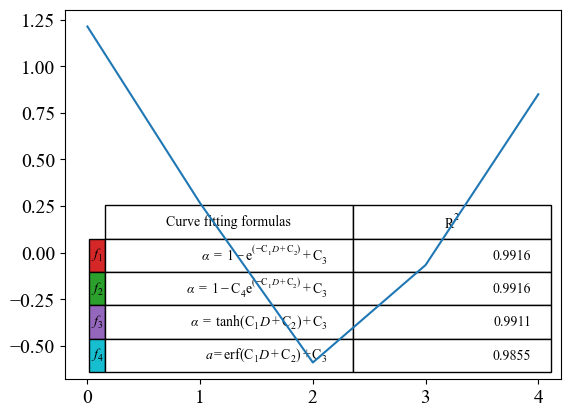

In [15]:
plt.figure()
ax = plt.gca()
a = np.random.randn(5)

f1 = r"$\alpha~=~1-\mathrm{e}^{(-\mathrm{C}_1 D +\mathrm{C}_2)}+\mathrm{C}_3$"
f2 = r"$\alpha~=~1-\mathrm{C}_4\mathrm{e}^{(-\mathrm{C}_1 D+\mathrm{C}_2)}+\mathrm{C}_3$"
f3 = r"$\alpha~=~\mathrm{tanh}(\mathrm{C}_1 D+\mathrm{C}_2)+\mathrm{C}_3$"
f4 = r"$a = \mathrm{erf}(\mathrm{C}_1 D+\mathrm{C}_2)+\mathrm{C}_3$"

#defining the attributes
col_labels = ['Curve fitting formulas',r'R$^2$']
row_labels = [r'$f_1$',r'$f_2$',r'$f_3$',r'$f_4$']
i=0
table_vals = [[f1, RT2[i]], [f2, RT2[i+1]], [f3, RT2[i+2]],[f4, RT2[i+3]]]
row_colors = ['C3', 'C2', 'C4','C9']
#plotting
table = plt.table(cellText=table_vals,
                     colWidths=[0.25,0.2],
                     rowLabels=row_labels,
                     colLabels=col_labels,
                     rowColours=row_colors,
                     loc='lower right')
table.set_fontsize(10)
table.scale(2,2)
plt.plot(a)
plt.show()

In [12]:
import numpy as np
from scipy.optimize import curve_fit, differential_evolution
font = 15
fontfml = 'Times New Roman'
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] =fontfml
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
#plt.rcParams['text.usetex'] = True

# remove default bold font setting--run only on Linux server
import matplotlib as mpl
#del mpl.font_manager.weight_dict['roman']
#mpl.font_manager._rebuild()
def sort_indices(x0,y0):
    sort_indices = np.argsort(y0)
    x_sorted = x0[sort_indices]
    y_sorted = y0[sort_indices]
    return x_sorted,y_sorted

In [13]:
cd=0

29.199014965896243 -2.3835731228442105 -0.741051215231471 0.0


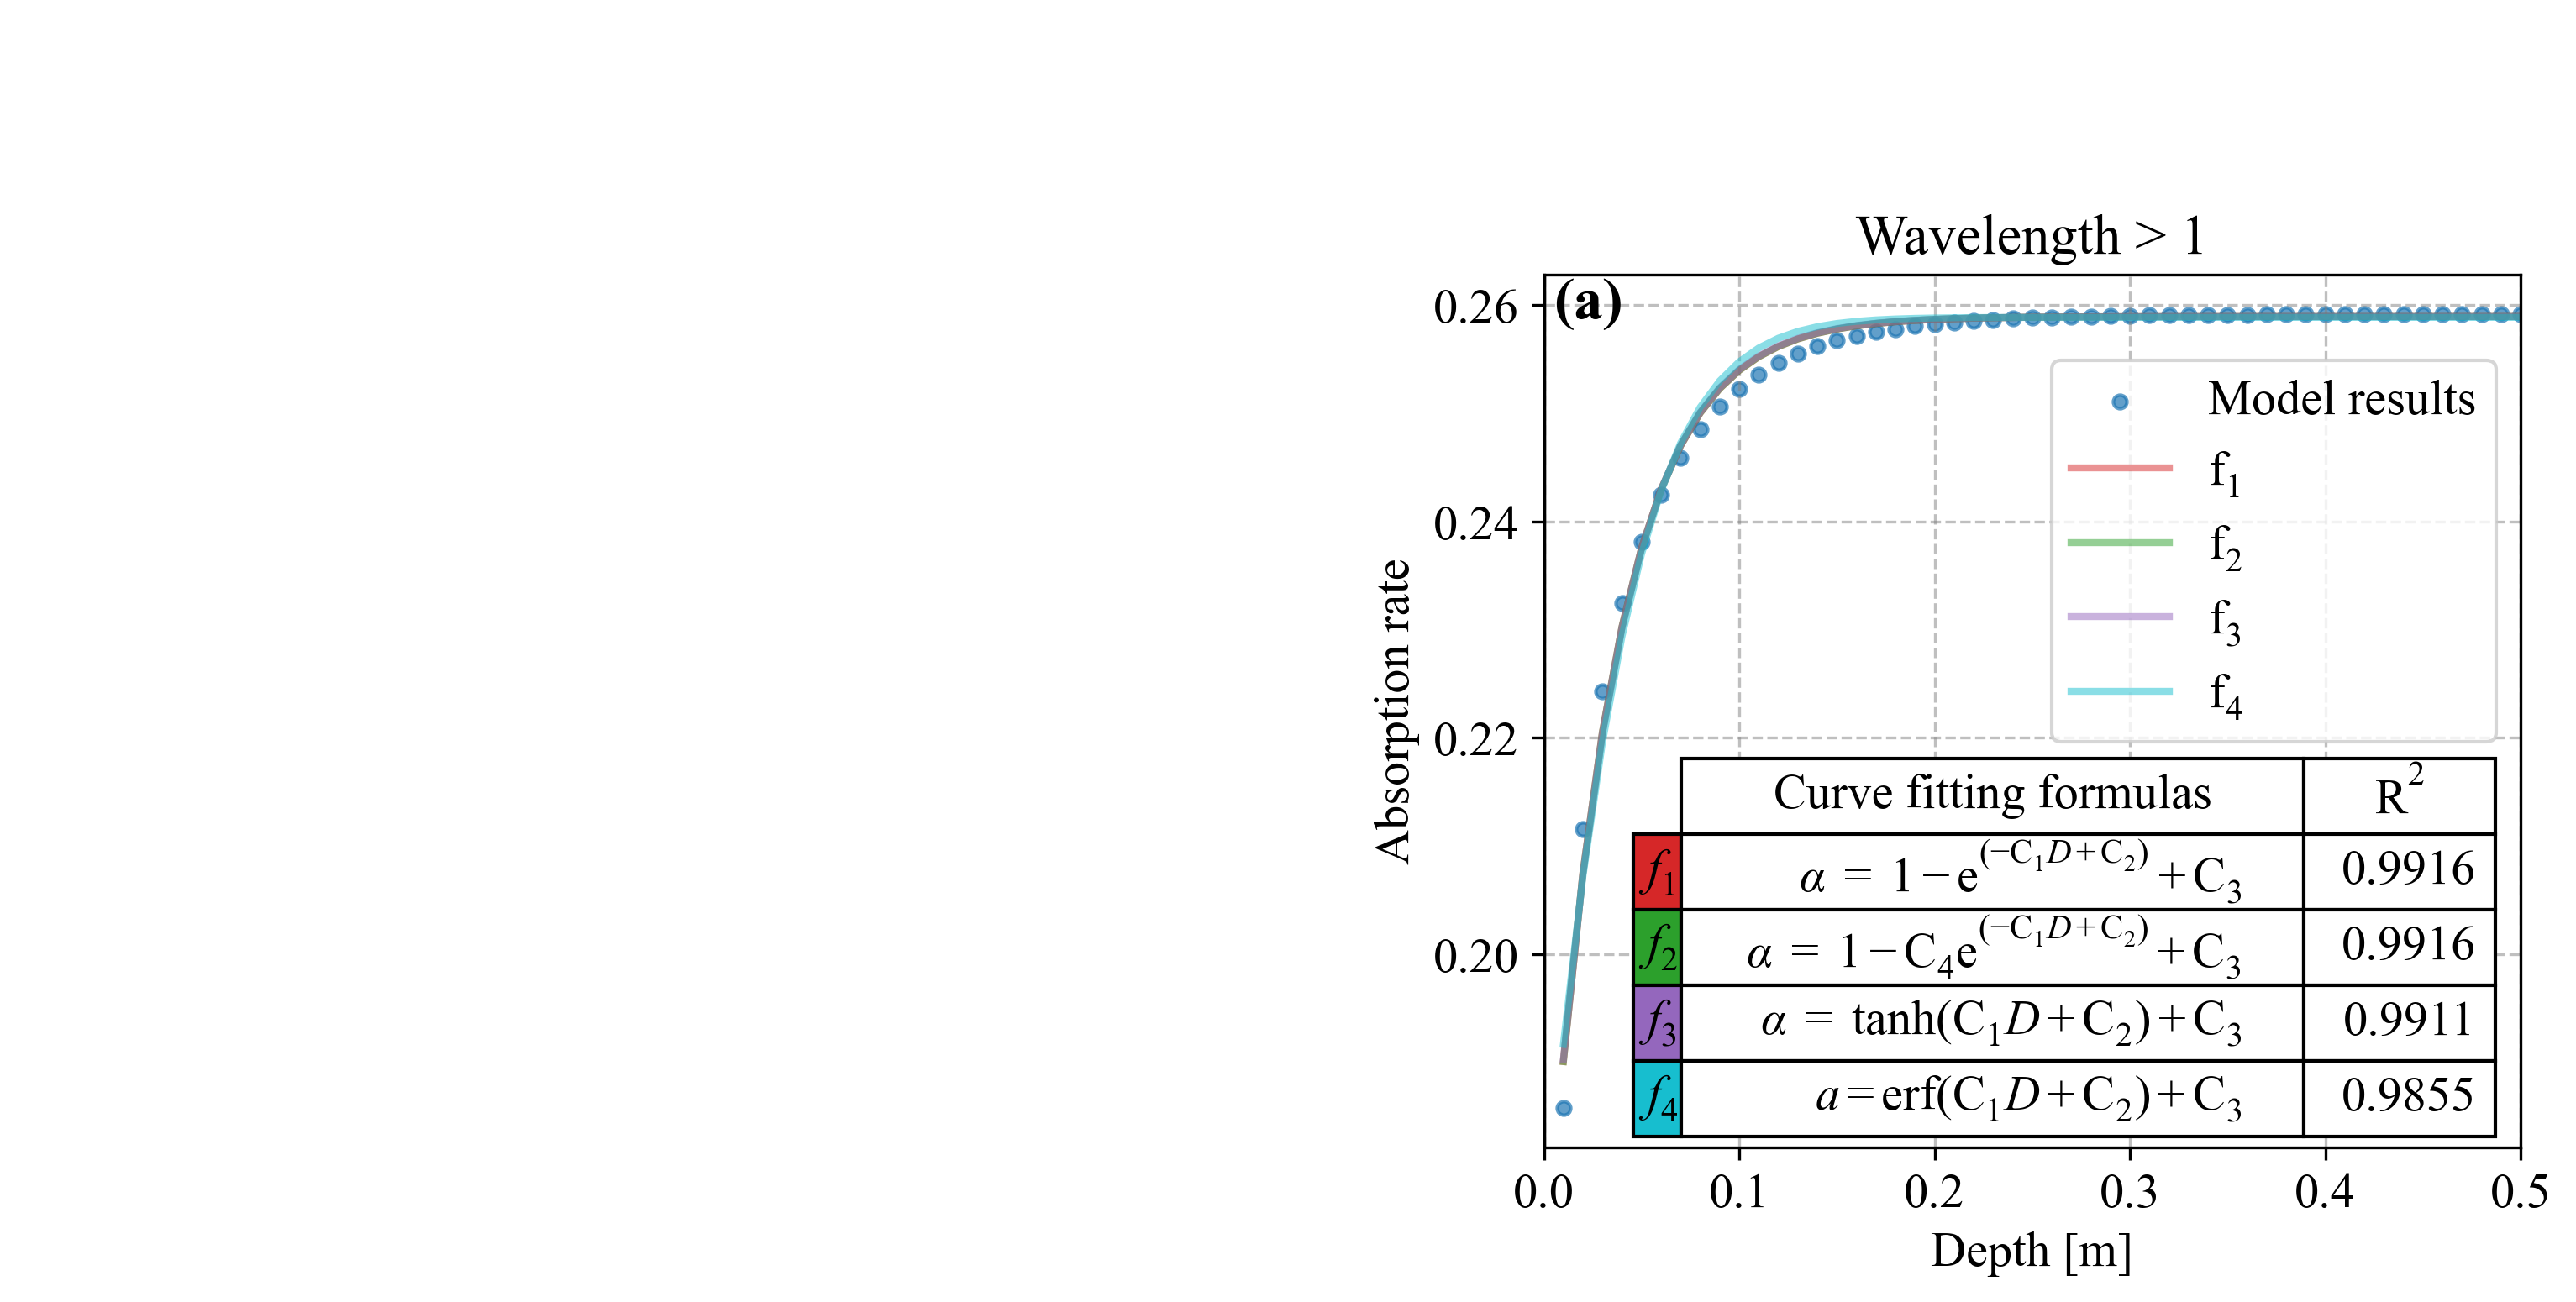

In [16]:
RT2=[]
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 14  # 

df = df.sort_values(by='layer')

fig, ax = plt.subplots(figsize=(5,4.5),dpi=300)
for p in range(1):
    # Loop through each row
    for index, row in df.iterrows():
        # Take the 'z' and 'int_abs' data for this row
        # z = row['z']
        x = row['z']/100 #*row['k_ave']/10000
        y = row['int_abs']

        if row['layer']==30:
            x_r1 = x#[:-3]
            y_r1 = y#[:-3]
        
        x_r1 = np.concatenate((x_r1,x[:-2]))
        y_r1 = np.concatenate((y_r1,y[:-2]))
        # Plot the data for this row, with the label set to the 'level' value
        # ax.scatter(x, y, s=3, alpha=0.7,color="C0")#label=f"{row['layer']} cm")
    
    y_r = y_r1
    x_r = x_r1
    if p==0:
        ax.scatter(x, y, s=15, alpha=0.7,color="C0", label="Model results")
        #ax.plot(x, y, alpha=0.7,color="C0", label="Model results")
    else:
        ax.scatter(x, y, s=15, alpha=0.7,color="C0")

    def func0(x, c1,c2,c3,c4):
        return 1-np.exp(-c1*x+c2)+c3    # 0.9781691501326472
    def func1(x, c1,c2,c3,c4):
        return 1-c4*np.exp(-c1*x+c2)+c3 # 0.978168785995655
    def func2(x, c1,c2,c3,c4):
        return np.tanh(c1*x+c2)+c3      # 0.9750128308493071
    def func3(x, c1,c2,c3,c4):
        return sp.erf(-c1*x+c2)+c3  # R2 0.9662096133561545

    # ------ plot -------- # 
    
    
    initial_guess = [1,-1,0,0]
    params, params_covariance = curve_fit(func0, x_r, y_r, p0=initial_guess,maxfev=100000)
    c1,c2,c3,c4 = params
    print(c1,c2,c3,c4)
    y0 = func0(x_r, c1,c2,c3,c4) # - -:+, cm-1xcm =>10^4
    temp = r2_score(y0, y_r)
    RT2.append(temp)
    #---
    initial_guess = [1,-1,0,0]
    params, params_covariance = curve_fit(func1, x_r, y_r, p0=initial_guess,maxfev=100000)
    c1,c2,c3,c4 = params
    y1 = func1(x_r, c1,c2,c3,c4)
    temp = r2_score(y1, y_r)
    RT2.append(temp)
    #----
    initial_guess = [1,-1,0,0]
    params, params_covariance = curve_fit(func2, x_r, y_r, p0=initial_guess,maxfev=100000)
    c1,c2,c3,c4 = params
    y2 = func2(x_r, c1,c2,c3,c4)
    temp = r2_score(y2, y_r)
    RT2.append(temp)
    #----
    initial_guess = [1.0,-1.0,0.0,0.0]
    x_r = np.array(x_r, dtype=float)
    y_r = np.array(y_r, dtype=float)
    params, params_covariance = curve_fit(func3, x_r, y_r, p0=initial_guess,maxfev=100000)
    c1,c2,c3,c4 = params
    y3 = func3(x_r, c1,c2,c3,c4)
    temp = r2_score(y3, y_r)
    RT2.append(temp)

    # ax.scatter(x_r,y_r,s=1.2,color=f'C{i}')
    # ax.scatter(x_r,y1,s=5,alpha=0.5,color='C2')
    # ax.scatter(x_r,y2,s=5,alpha=0.5,color='C4')
    # ax.scatter(x_r,y3,s=5,alpha=0.5,color='C9')
    if p ==0:
        x_i,y0 = sort_indices(x_r,y0)
        ax.plot(x_i,y0,alpha=0.5,color='C3',label=r"f$_1$",linewidth=2)
        x_i,y1 = sort_indices(x_r,y1)
        ax.plot(x_i,y1,alpha=0.5,color='C2',label=r"f$_2$",linewidth=2)
        x_i,y2 = sort_indices(x_r,y2)
        ax.plot(x_i,y2,alpha=0.5,color='C4',label=r"f$_3$",linewidth=2)
        x_i,y3 = sort_indices(x_r,y3)
        ax.plot(x_i,y3,alpha=0.5,color='C9',label=r"f$_4$",linewidth=2)
    else:
        ax.plot(x_r,y0,alpha=0.5,color='C1')
        ax.plot(x_r,y1,alpha=0.5,color='C2')
        ax.plot(x_r,y2,alpha=0.5,color='C4')
        ax.plot(x_r,y3,alpha=0.5,color='C9')
RT2 = np.array(RT2)
RT2 = np.around(RT2, 4)
ax.axvline(x=cd, color='k', linestyle='-',linewidth=0.8)
ax.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)

ax.legend(bbox_to_anchor=(1, 0.93), bbox_transform=ax.transAxes)#loc='center right')#title=r"$R^2$ value")
ax.set_xlabel(r'Depth [m]')
ax.set_ylabel('Absorption rate')


ax_table = plt.axes([-1.08, 0.1, 2, 1])

# Disable the axis (we only want the table to be visible)
ax_table.axis('off')

# Add the table to the custom axis
table = ax_table.table(cellText=table_vals,
                     colWidths=[0.26,0.08],
                     rowLabels=row_labels,
                     colLabels=col_labels,
                     rowColours=row_colors,
                     loc='lower right')
                     #bbox=[1, 0, 1, 1]) #[x, y, width, height]
table.set_fontsize(30)
table.scale(0.95,1.8) 
ax.set_xlim(0,0.5)
fig = plt.gcf()
figdir = './../../figure/'
ax.set_title('Wavelength > 1',fontsize=font+1)
ax.text(0.01, 0.95, '(a)', transform=ax.transAxes,fontsize=font+2,fontfamily=fontfml, weight='bold')
fig_dir = "../figure/"
plt.savefig(figdir+'solar_abs_lw.png',
            bbox_inches='tight',
            edgecolor=fig.get_edgecolor(),
            facecolor=fig.get_facecolor(),
            dpi=300)
plt.show()

## B. k-coeff and Temp

In [102]:
import scipy.integrate as integrate
Temp = np.arange(400,5800+1000,100)  # K
Temp1 = np.arange(300,400,1)
Temp = np.concatenate((Temp1,Temp))


In = np.zeros(Temp.shape[0])
Fdw = []

for tt in range(Temp.shape[0]):
    Fdw.append(Planck(nu,Temp[tt])*math.pi)
    In[tt] = integrate.trapz(Fdw[tt], nu)

In [103]:
Temp 

array([ 300,  301,  302,  303,  304,  305,  306,  307,  308,  309,  310,
        311,  312,  313,  314,  315,  316,  317,  318,  319,  320,  321,
        322,  323,  324,  325,  326,  327,  328,  329,  330,  331,  332,
        333,  334,  335,  336,  337,  338,  339,  340,  341,  342,  343,
        344,  345,  346,  347,  348,  349,  350,  351,  352,  353,  354,
        355,  356,  357,  358,  359,  360,  361,  362,  363,  364,  365,
        366,  367,  368,  369,  370,  371,  372,  373,  374,  375,  376,
        377,  378,  379,  380,  381,  382,  383,  384,  385,  386,  387,
        388,  389,  390,  391,  392,  393,  394,  395,  396,  397,  398,
        399,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200, 1300,
       1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400,
       2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
       3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600,
       4700, 4800, 4900, 5000, 5100, 5200, 5300, 54

In [104]:
ktdf = pd.DataFrame({'T':Temp,'intense':In, 'F_dw':Fdw})
k_abs = ka_lq_M[0]

def kave(Fdw,k_abs):
    """
    calculate the k_ave of each line
    """
    g = Fdw/np.sum(Fdw)
    N = k_abs.shape[0]
    k_ave = np.sum(k_abs*g)
    return k_ave

ktdf['k_ave'] = ktdf['F_dw'].apply(lambda x: kave(x, k_abs))

In [105]:
ktdf

,T,intense,F_dw,k_ave
0,300,9.802649e-01,"[0.00362903356260954, 0.0035643460977011696, 0...",950.566264
1,301,1.024407e+00,"[0.0037765084420575993, 0.0037094877297055326,...",957.127476
2,302,1.070243e+00,"[0.003928939789358778, 0.0038595193219460497, ...",963.689265
3,303,1.117826e+00,"[0.0040864563054179934, 0.0040145682533075135,...",970.251299
4,304,1.167210e+00,"[0.004249188897258582, 0.004174764097391468, 0...",976.813244
...,...,...,...,...
159,6300,2.057117e+07,"[759.3511916983714, 761.9152625496235, 764.481...",313.364215
160,6400,2.123651e+07,"[775.1775678255507, 777.8033153463068, 780.431...",310.525591
161,6500,2.190668e+07,"[791.0169027258813, 793.704429255049, 796.3946...",307.802346
162,6600,2.258152e+07,"[806.8686192379423, 809.6180226040898, 812.370...",305.187848


In [106]:
df['k_ave'][0]

61.87084503335973

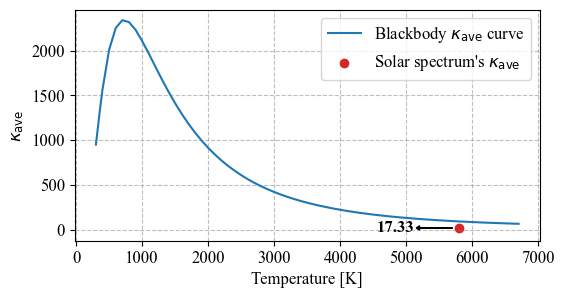

In [33]:
plt.rcParams['font.family'] = 'Times New Roman'  # For example, set font to Arial
plt.rcParams['font.size'] = 12  # 
font=12
fontfml='Times New Roman'
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(ktdf['T'], ktdf['k_ave'], label=r"Blackbody $\kappa_{\mathrm{ave}}$ curve")

ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r'$\kappa_{\mathrm{ave}}$')
ax.scatter(5800,df['k_ave'][0],color="C3", label="Solar spectrum's $\kappa_{\mathrm{ave}}$")
ax.text(0.65, 0.04, '17.33', transform=ax.transAxes, fontsize=font, family=fontfml,weight='bold')
ax.arrow(5700, 20, -500, 0, head_width=50, head_length=50, fc='blue', ec='black')
#ax.axvline(206.98,color='gray', linestyle='--',linewidth=1)
#ax.axvline(1159.1,color='gray', linestyle='--',linewidth=1)
ax.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
plt.legend()

fig_dir = "../../figure/"
fig.savefig(fig_dir+'pic.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()